In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 23s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
training_data_df['토지면적over총연면적times공시지가'] = training_data_df['토지면적'] / training_data_df['총연면적'] * training_data_df['공시지가(만원)']

In [13]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_37.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(37, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.602443,94.388346,96.111830,92.957121,91.612637,93.334475
토지면적over총연면적times공시지가,74.163810,74.558704,79.545529,72.882027,74.952550,75.220524
year_linear,65.404750,65.156917,67.992698,65.330043,64.883900,65.753661
건축년도,50.980140,51.739771,51.910116,53.337124,48.834999,51.360430
전용면적,38.252657,39.128785,39.248705,41.074392,39.777527,39.496413


In [14]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.602443,94.388346,96.111830,92.957121,91.612637,93.334475
토지면적over총연면적times공시지가,74.163810,74.558704,79.545529,72.882027,74.952550,75.220524
year_linear,65.404750,65.156917,67.992698,65.330043,64.883900,65.753661
건축년도,50.980140,51.739771,51.910116,53.337124,48.834999,51.360430
전용면적,38.252657,39.128785,39.248705,41.074392,39.777527,39.496413
ynorm,32.778974,33.334156,34.381181,31.948810,31.985028,32.885630
xy,23.169878,22.911403,23.088237,23.200194,22.130894,22.900121
x_2nd,20.970331,19.983670,19.086148,19.561174,18.775874,19.675439
층mean,14.252191,13.117314,10.635972,12.298080,14.361368,12.932985
주건축물수,11.275807,11.011066,11.722058,10.505324,12.096255,11.322102


In [15]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [16]:
top_22_df = shap_summary_df.iloc[:22,:]
print(top_22_df.shape)
top_22_df.head()

(22, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.602443,94.388346,96.111830,92.957121,91.612637,93.334475
토지면적over총연면적times공시지가,74.163810,74.558704,79.545529,72.882027,74.952550,75.220524
year_linear,65.404750,65.156917,67.992698,65.330043,64.883900,65.753661
건축년도,50.980140,51.739771,51.910116,53.337124,48.834999,51.360430
전용면적,38.252657,39.128785,39.248705,41.074392,39.777527,39.496413


In [17]:
top_22_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
year_linear,65.404750,65.156917,67.992698,65.330043,64.883900,65.753661
건축년도,50.980140,51.739771,51.910116,53.337124,48.834999,51.360430
전용면적,38.252657,39.128785,39.248705,41.074392,39.777527,39.496413
ynorm,32.778974,33.334156,34.381181,31.948810,31.985028,32.885630
xy,23.169878,22.911403,23.088237,23.200194,22.130894,22.900121
x_2nd,20.970331,19.983670,19.086148,19.561174,18.775874,19.675439
층mean,14.252191,13.117314,10.635972,12.298080,14.361368,12.932985
주건축물수,11.275807,11.011066,11.722058,10.505324,12.096255,11.322102
총건축면적,10.487300,8.622428,8.299764,10.033140,8.801621,9.248851
호수대비연면적,9.882119,8.960873,8.050227,8.596309,9.848030,9.067512


In [18]:
training_data_df = training_data_df[top_22_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 27)


,trade_type,토지면적over총연면적times공시지가,year_linear,건축년도,전용면적,ynorm,xy,x_2nd,층mean,주건축물수,총건축면적,호수대비연면적,토지이동상황,xnorm,아파트지구,옥내자주식대수,호수대비부속건축물면적,총호수,층,y_2nd,호수대비주차수,용도지역명1,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,758.319895,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,2,4.094180e+07,0.0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,758.319895,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,2,4.094180e+07,0.0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,758.319895,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,4,4.094180e+07,0.0,0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,758.319895,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,9,4.094180e+07,0.0,0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,758.319895,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,1,4.094180e+07,0.0,0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [19]:
from sklearn.model_selection import KFold, GroupKFold

In [20]:
import lightgbm as lgb

In [21]:
from sklearn.metrics import r2_score

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

4

In [24]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 22)
y dist plot


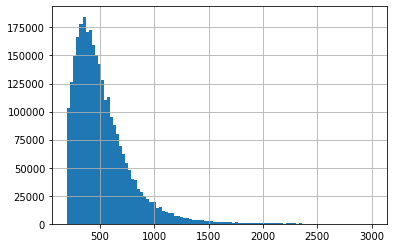

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3943
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 22


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 100 rounds
[50]	valid_0's huber: 105.216
[100]	valid_0's huber: 87.9441
[150]	valid_0's huber: 80.4332
[200]	valid_0's huber: 76.3748
[250]	valid_0's huber: 73.5975
[300]	valid_0's huber: 71.6389
[350]	valid_0's huber: 69.9107
[400]	valid_0's huber: 68.4766
[450]	valid_0's huber: 67.1554
[500]	valid_0's huber: 66.0036
[550]	valid_0's huber: 65.1058
[600]	valid_0's huber: 64.3647
[650]	valid_0's huber: 63.5871
[700]	valid_0's huber: 62.9105
[750]	valid_0's huber: 62.2768
[800]	valid_0's huber: 61.7132
[850]	valid_0's huber: 61.194
[900]	valid_0's huber: 60.6523
[950]	valid_0's huber: 60.1967
[1000]	valid_0's huber: 59.7787
[1050]	valid_0's huber: 59.4351
[1100]	valid_0's huber: 59.0376
[1150]	valid_0's huber: 58.7181
[1200]	valid_0's huber: 58.4063
[1250]	valid_0's huber: 58.1119
[1300]	valid_0's huber: 57.8714
[1350]	valid_0's huber: 57.6083
[1400]	valid_0's huber: 57.3605
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


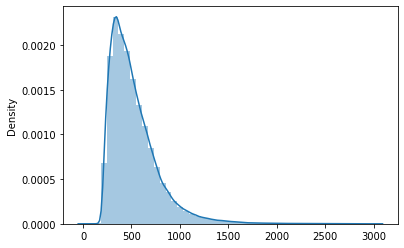

Fold 0 end
Fold 1 start
(2926581, 22)
y dist plot


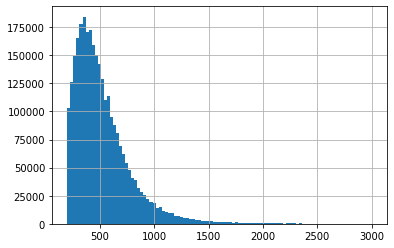

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3942
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 22


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 100 rounds
[50]	valid_0's huber: 105.405
[100]	valid_0's huber: 88.291
[150]	valid_0's huber: 80.6858
[200]	valid_0's huber: 76.3742
[250]	valid_0's huber: 73.6617
[300]	valid_0's huber: 71.386
[350]	valid_0's huber: 69.6893
[400]	valid_0's huber: 68.4172
[450]	valid_0's huber: 67.3947
[500]	valid_0's huber: 66.354
[550]	valid_0's huber: 65.2524
[600]	valid_0's huber: 64.308
[650]	valid_0's huber: 63.5827
[700]	valid_0's huber: 62.8218
[750]	valid_0's huber: 62.1676
[800]	valid_0's huber: 61.578
[850]	valid_0's huber: 60.9957
[900]	valid_0's huber: 60.5135
[950]	valid_0's huber: 60.0354
[1000]	valid_0's huber: 59.6108
[1050]	valid_0's huber: 59.1968
[1100]	valid_0's huber: 58.8482
[1150]	valid_0's huber: 58.5371
[1200]	valid_0's huber: 58.2281
[1250]	valid_0's huber: 57.9538
[1300]	valid_0's huber: 57.693
[1350]	valid_0's huber: 57.4055
[1400]	valid_0's huber: 57.1455
[1450]	valid_

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


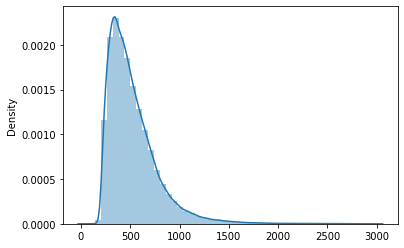

Fold 1 end
Fold 2 start
(2926581, 22)
y dist plot


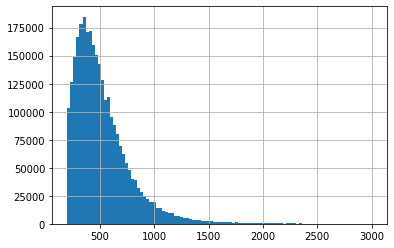

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3942
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 22


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 100 rounds
[50]	valid_0's huber: 105.074
[100]	valid_0's huber: 88.0337
[150]	valid_0's huber: 80.6565
[200]	valid_0's huber: 76.3915
[250]	valid_0's huber: 73.464
[300]	valid_0's huber: 71.1647
[350]	valid_0's huber: 69.4339
[400]	valid_0's huber: 67.9557
[450]	valid_0's huber: 66.6848
[500]	valid_0's huber: 65.6944
[550]	valid_0's huber: 64.8991
[600]	valid_0's huber: 64.1034
[650]	valid_0's huber: 63.289
[700]	valid_0's huber: 62.6116
[750]	valid_0's huber: 61.9688
[800]	valid_0's huber: 61.4367
[850]	valid_0's huber: 60.9339
[900]	valid_0's huber: 60.4976
[950]	valid_0's huber: 60.0534
[1000]	valid_0's huber: 59.6311
[1050]	valid_0's huber: 59.2639
[1100]	valid_0's huber: 58.9124
[1150]	valid_0's huber: 58.5926
[1200]	valid_0's huber: 58.2677
[1250]	valid_0's huber: 57.9549
[1300]	valid_0's huber: 57.7111
[1350]	valid_0's huber: 57.4499
[1400]	valid_0's huber: 57.2132
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


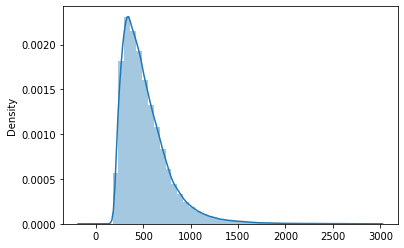

Fold 2 end
Fold 3 start
(2926581, 22)
y dist plot


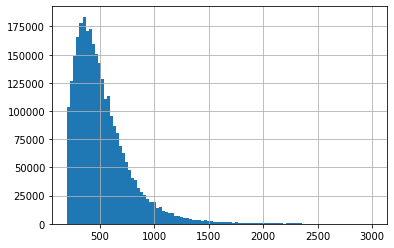

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3941
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 22


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 100 rounds
[50]	valid_0's huber: 104.96
[100]	valid_0's huber: 88.4021
[150]	valid_0's huber: 81.2211
[200]	valid_0's huber: 76.6206
[250]	valid_0's huber: 73.553
[300]	valid_0's huber: 71.1857
[350]	valid_0's huber: 69.5727
[400]	valid_0's huber: 68.0638
[450]	valid_0's huber: 66.7771
[500]	valid_0's huber: 65.5941
[550]	valid_0's huber: 64.6523
[600]	valid_0's huber: 63.9258
[650]	valid_0's huber: 63.2219
[700]	valid_0's huber: 62.4462
[750]	valid_0's huber: 61.8657
[800]	valid_0's huber: 61.3843
[850]	valid_0's huber: 60.9198
[900]	valid_0's huber: 60.439
[950]	valid_0's huber: 59.9762
[1000]	valid_0's huber: 59.6544
[1050]	valid_0's huber: 59.2712
[1100]	valid_0's huber: 58.911
[1150]	valid_0's huber: 58.5577
[1200]	valid_0's huber: 58.2795
[1250]	valid_0's huber: 57.9602
[1300]	valid_0's huber: 57.6743
[1350]	valid_0's huber: 57.3908
[1400]	valid_0's huber: 57.14
[1450]	valid_

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


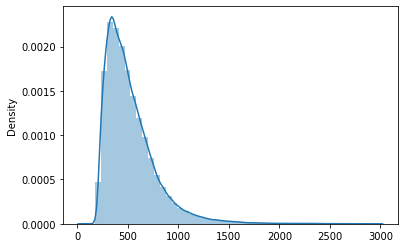

Fold 3 end
Fold 4 start
(2926581, 22)
y dist plot


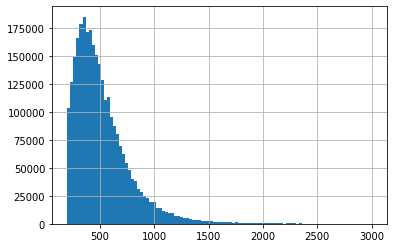

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3942
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 22


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 100 rounds
[50]	valid_0's huber: 104.996
[100]	valid_0's huber: 87.9133
[150]	valid_0's huber: 80.4886
[200]	valid_0's huber: 76.2752
[250]	valid_0's huber: 73.6328
[300]	valid_0's huber: 71.4436
[350]	valid_0's huber: 69.7711
[400]	valid_0's huber: 68.1954
[450]	valid_0's huber: 66.98
[500]	valid_0's huber: 65.9089
[550]	valid_0's huber: 65.0444
[600]	valid_0's huber: 64.262
[650]	valid_0's huber: 63.4981
[700]	valid_0's huber: 62.7953
[750]	valid_0's huber: 62.1697
[800]	valid_0's huber: 61.5347
[850]	valid_0's huber: 61.0354
[900]	valid_0's huber: 60.5596
[950]	valid_0's huber: 60.1579
[1000]	valid_0's huber: 59.6866
[1050]	valid_0's huber: 59.3261
[1100]	valid_0's huber: 59.0023
[1150]	valid_0's huber: 58.7246
[1200]	valid_0's huber: 58.393
[1250]	valid_0's huber: 58.0961
[1300]	valid_0's huber: 57.8157
[1350]	valid_0's huber: 57.5602
[1400]	valid_0's huber: 57.3401
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


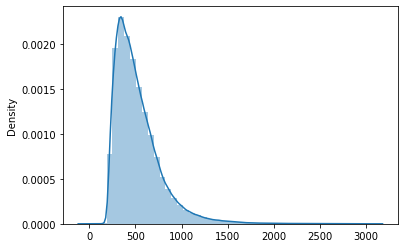

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [25]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'alpha': 1.35,
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 50000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=100, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_22_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
    
    print('Fold {} end'.format(count))
    count += 1

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

65.1989313145655

In [28]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [29]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [30]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [31]:
shap_summary_df.index = x_train.columns

In [32]:
shap_summary_df.to_csv(basedir + 'shap_top_22.csv')

In [33]:
shap_summary_df = shap_summary_df.sort_values(['shap_summary_mean'], ascending=False)

In [34]:
shap_summary_df.shape

(22, 6)

In [35]:
shap_summary_df

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.430898,94.244723,93.464060,92.497628,97.691024,94.265667
토지면적over총연면적times공시지가,77.816755,75.929762,76.607000,74.430997,73.536234,75.664150
year_linear,64.501899,64.793292,63.739718,64.187489,65.249342,64.494348
건축년도,52.283525,51.474565,51.722165,53.150375,52.650023,52.256131
전용면적,38.522842,39.599181,39.721055,42.076516,38.155590,39.615037
ynorm,34.489532,34.013167,33.730655,33.089798,35.632384,34.191107
xy,23.326864,24.154214,24.865810,23.859642,25.773473,24.396001
x_2nd,19.760007,19.156116,18.156039,22.497065,20.772915,20.068428
층mean,13.300747,12.738585,13.020225,11.960626,12.300522,12.664141
주건축물수,12.753585,12.931364,12.756476,11.482845,11.969258,12.378706


In [36]:
#